# **Práctica Módulo Deep Learning - Objetivo**

Implementar un algoritmo predictivo que sea capaz de estimar el precio de las habitaciones utilizando para ello datos de distintos tipos y técnicas de Deep Learning (redes neuronales profundas). Se puede dividir en dos módulos:


*   Primer módulo: estimación de los precios de las habitaciones mediante un modelo basado en imágenes y un modelo basado en datos 1D (ML Tradicional) y con Redes Neuronales.
*   Segundo módulo: desarrollar un único modelo que combine datos 1-D e imágenes para calcular los precios de las habitaciones (modelo híbrido).

## Primero, descargo el fichero csv desde la URL de descarga e importo librerías que voy a utilizar 📃:

In [1]:
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2023-07-16 15:34:02--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [    <=>             ]  54.31M  3.09MB/s    in 18s     

2023-07-16 15:34:21 (2.98 MB/s) - ‘airbnb-listings.csv’ saved [56950929]



In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

# Para mostrar todas las columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Lo primero que tenemos que hacer es cargar las imágenes con las que vamos a trabajar.

---


### Vamos a abrir con Pandas el fichero, eliminamos filas con valores NA en la variable a predecir **'Price'** y de la variable de donde obtendremos las imágenes y comprobamos que se ha importado bien:

In [3]:
full_df = pd.read_csv('airbnb-listings.csv', sep=';', decimal='.')

full_df = full_df.dropna(subset=['Picture Url'])
full_df = full_df.dropna(subset=['Price'])
full_df.head(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,15459188,https://www.airbnb.com/rooms/15459188,20170407214050,2017-04-08,Paseo De Gracia I (433),"Unique apartment in vibrant neighborhoods, car...","Its high ceilings, wooden floors, large window...","Unique apartment in vibrant neighborhoods, car...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/ced19499-8...,https://a0.muscache.com/im/pictures/ced19499-8...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ced19499-8...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalunya,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.391616,2.168168,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,94.0,NaN,NaN,NaN,NaN,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,2017-04-08,1,2017-01-22,2017-01-22,60.0,6.0,8.0,10.0,6.0,10.0,8.0,NaN,NaN,strict,92,0.39,"41.39161588920901,2.1681677061165425","Host Has Profile Pic,Host Identity Verified,Is..."
1,13184463,https://www.airbnb.com/rooms/13184463,20170407214050,2017-04-08,"Rooftop 2 terraces full of art, style and views","Our place is In the cross between Born, Barce...",The views above Barcelona are unique. The styl...,"Our place is In the cross between Born, Barce...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/6e41526e-e...,https://a0.muscache.com/im/pictures/6e41526e-e...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/6e41526e-e...,5143182,https://www.airbnb.com/users/show/5143182,Ana,2013-02-19,"Barcelona, Catalonia, Spain","De Madrid, viviendo en Barcelona. Viajera, cur...",within a day,90.0,NaN,https://a0.muscache.com/im/users/5143182/profi...,https://a0.muscache.com/im/users/5143182/profi...,El Gòtic,1.0,1.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.381369,2.180874,Apartment,Entire home/apt,3,1.5,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Pets...",NaN,115.0,NaN,NaN,NaN,20.0,2,20,1,30,4 weeks ago,NaN,0,0,0,98,2017-04-07,9,2016-07-11,2017-03-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,flexible,1,0.99,"41.38136867557121,2.1808743514708038","Host Has Profile Pic,Host Identity Verified,Is..."
2,17115175,https://www.airbnb.com/room

Para la descarga de las fotografías, vamos a iterar sobre el dataset completo buscando la columna de *Picture Url* . Igual que hemos hecho con *Price*, vamos ya eliminamos anteriormente aquellas entradas en las que el valor de la URL sea un NA.

## Procedo a la descarga de las imágenes 🖼:

In [4]:
import imageio.v3 as io
import cv2
from tqdm import tqdm
from typing import Optional, Union

In [5]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=np.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

Normalización y conversión al rango [0,1] de todas las imágenes:

In [6]:
images, idxs = download_images(full_df['Picture Url'], max_imgs=2000)
images = images.astype("float32") / 255.
images.shape

100%|██████████| 2000/2000 [23:34<00:00,  1.41it/s]


(2000, 224, 224, 3)

Con los índices que nos devuelve la función *download_images* sabemos cuáles con las entradas del csv que tenían una imagen válida, así que filtraremos el dataframe acorde a estos:

In [7]:
filtered_data = full_df.iloc[idxs]
filtered_data.head(5)

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,15459188,https://www.airbnb.com/rooms/15459188,20170407214050,2017-04-08,Paseo De Gracia I (433),"Unique apartment in vibrant neighborhoods, car...","Its high ceilings, wooden floors, large window...","Unique apartment in vibrant neighborhoods, car...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/ced19499-8...,https://a0.muscache.com/im/pictures/ced19499-8...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/ced19499-8...,54310958,https://www.airbnb.com/users/show/54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",Be Mate offers the exclusive City Mate service...,within an hour,99.0,NaN,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,https://a0.muscache.com/im/pictures/8f3ec0f2-1...,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalunya,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.391616,2.168168,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,94.0,NaN,NaN,NaN,NaN,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,2017-04-08,1,2017-01-22,2017-01-22,60.0,6.0,8.0,10.0,6.0,10.0,8.0,NaN,NaN,strict,92,0.39,"41.39161588920901,2.1681677061165425","Host Has Profile Pic,Host Identity Verified,Is..."
1,13184463,https://www.airbnb.com/rooms/13184463,20170407214050,2017-04-08,"Rooftop 2 terraces full of art, style and views","Our place is In the cross between Born, Barce...",The views above Barcelona are unique. The styl...,"Our place is In the cross between Born, Barce...",none,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/6e41526e-e...,https://a0.muscache.com/im/pictures/6e41526e-e...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/6e41526e-e...,5143182,https://www.airbnb.com/users/show/5143182,Ana,2013-02-19,"Barcelona, Catalonia, Spain","De Madrid, viviendo en Barcelona. Viajera, cur...",within a day,90.0,NaN,https://a0.muscache.com/im/users/5143182/profi...,https://a0.muscache.com/im/users/5143182/profi...,El Gòtic,1.0,1.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.381369,2.180874,Apartment,Entire home/apt,3,1.5,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Pets...",NaN,115.0,NaN,NaN,NaN,20.0,2,20,1,30,4 weeks ago,NaN,0,0,0,98,2017-04-07,9,2016-07-11,2017-03-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,flexible,1,0.99,"41.38136867557121,2.1808743514708038","Host Has Profile Pic,Host Identity Verified,Is..."
2,17115175,https://www.airbnb.com/room

Ahora guardamos los datos descargados para poder usarlos en nuestro Modelo:

In [8]:
np.save('images.npy', images)
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)

Conectamos Colab a Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp images.npy /content/drive/MyDrive/images_final.npy
!cp filtered_data.csv /content/drive/MyDrive/filtered_data.csv

!ls -lah images* filtered*  # Comprobación

-rw-r--r-- 1 root root 7.9M Jul 16 15:58 filtered_data.csv
-rw-r--r-- 1 root root 1.2G Jul 16 15:58 images.npy


In [11]:
# Comprobamos abriéndolos de nuevo
saved_data = pd.read_csv("/content/drive/MyDrive/filtered_data.csv", sep=';')
saved_imgs = np.load("/content/drive/MyDrive/images_final.npy")
saved_data.shape, saved_imgs.shape

((2000, 89), (2000, 224, 224, 3))

## 1. Modelo de datos 1D (Tabulares) 📆

Veo qué columnas tenemos:

In [12]:
colnames = list(filtered_data.columns)
colnames

['ID',
 'Listing Url',
 'Scrape ID',
 'Last Scraped',
 'Name',
 'Summary',
 'Space',
 'Description',
 'Experiences Offered',
 'Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Interaction',
 'House Rules',
 'Thumbnail Url',
 'Medium Url',
 'Picture Url',
 'XL Picture Url',
 'Host ID',
 'Host URL',
 'Host Name',
 'Host Since',
 'Host Location',
 'Host About',
 'Host Response Time',
 'Host Response Rate',
 'Host Acceptance Rate',
 'Host Thumbnail Url',
 'Host Picture Url',
 'Host Neighbourhood',
 'Host Listings Count',
 'Host Total Listings Count',
 'Host Verifications',
 'Street',
 'Neighbourhood',
 'Neighbourhood Cleansed',
 'Neighbourhood Group Cleansed',
 'City',
 'State',
 'Zipcode',
 'Market',
 'Smart Location',
 'Country Code',
 'Country',
 'Latitude',
 'Longitude',
 'Property Type',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Bed Type',
 'Amenities',
 'Square Feet',
 'Price',
 'Weekly Price',
 'Monthly Price',
 'Security Deposit',
 'Cleaning Fee

Tamaño del dataframe:

In [13]:
filtered_data.shape

(2000, 89)

### Hay muchísimas variables en el dataframe, y por conocimiento previo, sé que muchas son inservibles. Así que voy a eliminar todas ellas que contienen otras URLs que no voy a usar, datos de la etapa de scrapping, campos con texto libre..

In [14]:
#Campos de texto plano:
filtered_data = filtered_data.drop(['Features','Name','Space','Summary','Description','Neighborhood Overview','Host Name','Notes','Host About','Access', 'Interaction', 'House Rules'], axis=1)

#También columnas con URL excepto la que vamos a usar para descargar las imágenes con las que haremos la predicción:
#Busco todas las columnas que contengan 'URL'
for i in range(len(colnames)):
    if 'URL' in colnames[i] or 'Url' in colnames[i] and colnames[i] != 'Picture Url':
        filtered_data = filtered_data.drop(colnames[i], axis = 1)

#Variables relacionadas con IDs, datos del scrapping...
filtered_data = filtered_data.drop(['ID', 'Last Scraped','Calendar last Scraped','Scrape ID', 'Host ID', 'License'], axis=1)


filtered_data.head(5)

,Experiences Offered,Transit,Picture Url,Host Since,Host Location,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation
0,none,NaN,https://public.opendatasoft.com/api/v2/catalog...,2016-01-12,"Madrid, Community of Madrid, Spain",within an hour,99.0,NaN,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalunya,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.391616,2.168168,Apartment,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,94.0,NaN,NaN,NaN,NaN,1,0,2,1125,2 weeks ago,NaN,0,0,0,0,1,2017-01-22,2017-01-22,60.0,6.0,8.0,10.0,6.0,10.0,8.0,NaN,strict,92,0.39,"41.39161588920901,2.1681677061165425"
1,none,NaN,https://public.opendatasoft.com/api/v2/catalog...,2013-02-19,"Barcelona, Catalonia, Spain",within a day,90.0,NaN,El Gòtic,1.0,1.0,"email,phone,reviews,jumio","El Gòtic, Barcelona, Catalunya 08002, Spain",El Gòtic,el Barri Gòtic,Ciutat Vella,Barcelona,Catalunya,08002,Barcelona,"Barcelona, Spain",ES,Spain,41.381369,2.180874,Apartment,Entire home/apt,3,1.5,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Pets...",NaN,115.0,NaN,NaN,NaN,20.0,2,20,1,30,4 weeks ago,NaN,0,0,0,98,9,2016-07-11,2017-03-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,flexible,1,0.99,"41.38136867557121,2.1808743514708038"
2,none,Blue underground line - 5 minutes walking Sant...,https://public.opendatasoft.com/api/v2/catalog...,2014-11-21,"Madrid, Community of Madrid, Spain",within an hour,100.0,NaN,L'Antiga Esquerra de l'Eixample,1.0,1.0,"email,phone,reviews,jumio","L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",L'Antiga Esquerra de l'Eixample,la Nova Esquerra de l'Eixample,Eixample,Barcelona,Catalunya,08029,Barcelona,"Barcelona, Spain",ES,Spain,41.386005,2.143397,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,200.0,NaN,NaN,NaN,NaN,1,0,3,5,5 weeks ago,NaN,11,39,69,70,1,2017-03-02,2017-03-02,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,strict,1,0.79,"41.38600531434205,2.1433972223397064"
3,none,"Whatever it is you came to see in Barcelona, I...",https://public.opendatasoft.com/api/v2/catalog...,2010-05-25,"Barcelona, Cataluña, Spain",within an hour,100.0,NaN,El Born,27.0,27.0,"email,phone,facebook,reviews,manual_offline,ju...","Dreta de l'Eixample, Barcelona, Catalonia 0800...",Dreta de l'Eixample,la Dreta de l'Eixample,Eixample,Barcelona,Catalonia,08009,Barcelona,"Barcelona, Spain",ES,Spain,41.397181,2.169227,Apartment,Entire home/apt,8,2.0,3.0,4.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Air con...",NaN,169.0,NaN,NaN,250.0,79.0,2,39,1,90,today,NaN,20,33,53,322,90,2013-07-09,2017-01-01,91.0,9.0,10.0,10.0,10.0,10.0,9.0,NaN,strict,24,1.97,"41.39718124558758,2.1692269203074326"
4,none,NaN,https://public.opendatasoft.com/api/v2/catalog...,2016-01-12,"Madrid, Community of Madrid, Spain",within an hour,99.0,NaN,L'Antiga Esquerra de l'Eixample,207.0,207.0,"email,phone,reviews,jumio","Dreta de l'Eixample, Barcelona, Catalunya 0800...",Dreta de l'Eixample,la Dreta de l'Eix

Pintamos un histograma de los precios (etiquetas) del dataframe:

<Axes: >

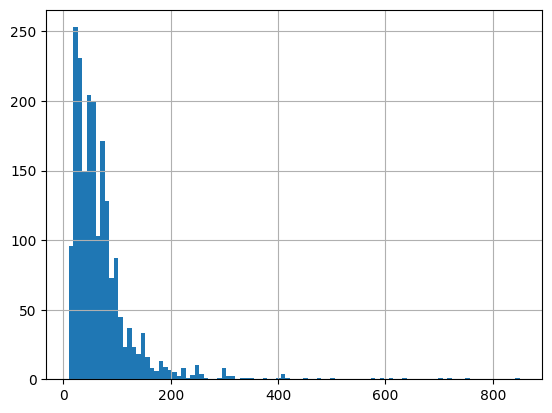

In [15]:
filtered_data['Price'].hist(bins=100)

In [16]:
filtered_data['Price'].describe()

count    2000.000000
mean       70.694500
std        67.179206
min        10.000000
25%        33.000000
50%        55.000000
75%        82.250000
max       850.000000
Name: Price, dtype: float64

## A partir de ahora, y una vez hecho este primer preprocesado general, voy a quedarme con las variables de mayor interés que se indican en el guión orientativo de la práctica.



A partir de esta aproximación inicial haré un análisis exploratorio en el conjunto de train que validaré con los conjuntos de val y test.

In [17]:
keep_columns = ['Property Type', 'Room Type', 'Cancellation Policy', 'Accommodates', 'Bathrooms', 'Bedrooms',
'Beds','Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews', 'Host Total Listings Count', 'Price']

filtered_data = filtered_data[keep_columns]

filtered_data.head(3)

,Property Type,Room Type,Cancellation Policy,Accommodates,Bathrooms,Bedrooms,Beds,Guests Included,Extra People,Minimum Nights,Maximum Nights,Number of Reviews,Host Total Listings Count,Price
0,Apartment,Entire home/apt,strict,4,1.0,2.0,3.0,1,0,2,1125,1,207.0,94.0
1,Apartment,Entire home/apt,flexible,3,1.5,1.0,1.0,2,20,1,30,9,1.0,115.0
2,Apartment,Private room,strict,1,1.0,1.0,1.0,1,0,3,5,1,1.0,200.0


## Ya podemos identificar y categorizar la variable objetivo (Price) y convertirla a one-hot-encoding.


## También haremos la división en *train, val y test* para seguir el análisis exploratorio sólo con el conjunto de *train*

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = filtered_data.drop('Price', axis=1)
y = filtered_data['Price']

# Creamos las categorias de precios para el clasificador y codificamos:
price_categories = ['Economic', 'Standard', 'Expensive']

y_categories = pd.qcut(y, q=len(price_categories), labels=price_categories)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)
y_one_hot = to_categorical(y_encoded, num_classes=len(price_categories))


# Hacemos la división de los datos para el modelo tabular y estratificamos con respecto a la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=1)
                                                    #, stratify = y_one_hot)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)
                                                  #, stratify = y_train)


# Verificar los tamaños de los conjuntos
print(f'x train: ', X_train.shape)
print(f'x test: ', X_test.shape)
print(f'x val: ', X_val.shape)
print('---')
print(f'y train: ', y_train.shape)
print(f'y test: ', y_test.shape)
print(f'y val: ', y_val.shape)


x train:  (1360, 13)
x test:  (400, 13)
x val:  (240, 13)
---
y train:  (1360, 3)
y test:  (400, 3)
y val:  (240, 3)


Comienzo análisis exploratorio considerando solamente el conjunto X_train

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1360 entries, 811 to 1673
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Property Type              1360 non-null   object 
 1   Room Type                  1360 non-null   object 
 2   Cancellation Policy        1360 non-null   object 
 3   Accommodates               1360 non-null   int64  
 4   Bathrooms                  1351 non-null   float64
 5   Bedrooms                   1356 non-null   float64
 6   Beds                       1352 non-null   float64
 7   Guests Included            1360 non-null   int64  
 8   Extra People               1360 non-null   int64  
 9   Minimum Nights             1360 non-null   int64  
 10  Maximum Nights             1360 non-null   int64  
 11  Number of Reviews          1360 non-null   int64  
 12  Host Total Listings Count  1360 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usag

Tengo valores nulos en: Bathrooms, Bedrooms y Beds. También en Host Total Listings Count. Los voy a imputar haciendo uso de la moda:

In [20]:
X_train["Bathrooms"].fillna(X_train["Bathrooms"].mode()[0], inplace=True)
X_train["Bedrooms"].fillna(X_train["Bedrooms"].mode()[0], inplace=True)
X_train["Beds"].fillna(X_train["Beds"].mode()[0], inplace=True)
X_train["Host Total Listings Count"].fillna(X_train["Host Total Listings Count"].mode()[0], inplace=True)

También tengo que transformar variables no numéricas a variables numéricas, haciendo uso de LabelEncoder

In [21]:
le_proptype = LabelEncoder()
X_train["Property Type"] = le_proptype.fit_transform(X_train["Property Type"])

In [22]:
le_roomtype = LabelEncoder()
X_train["Room Type"] = le_roomtype.fit_transform(X_train["Room Type"])

In [23]:
le_cancel = LabelEncoder()
X_train["Cancellation Policy"] = le_cancel.fit_transform(X_train["Cancellation Policy"])

Chequeo que estos pasos hayan ido bien:

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1360 entries, 811 to 1673
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Property Type              1360 non-null   int64  
 1   Room Type                  1360 non-null   int64  
 2   Cancellation Policy        1360 non-null   int64  
 3   Accommodates               1360 non-null   int64  
 4   Bathrooms                  1360 non-null   float64
 5   Bedrooms                   1360 non-null   float64
 6   Beds                       1360 non-null   float64
 7   Guests Included            1360 non-null   int64  
 8   Extra People               1360 non-null   int64  
 9   Minimum Nights             1360 non-null   int64  
 10  Maximum Nights             1360 non-null   int64  
 11  Number of Reviews          1360 non-null   int64  
 12  Host Total Listings Count  1360 non-null   float64
dtypes: float64(4), int64(9)
memory usage: 148.8 KB

Voy a pintar las variables que parecen más relevantes, a priori, para determinar el precio y así ver si hay valores *outlier*:

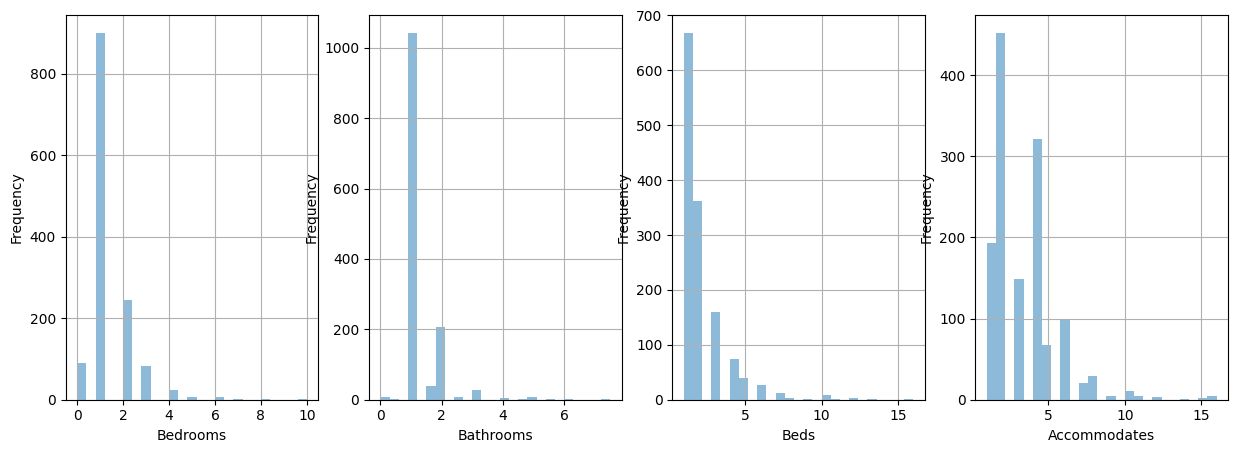

In [25]:
import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
X_train['Bedrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Bedrooms')

plt.subplot(1,4,2)
X_train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Bathrooms')

plt.subplot(1,4,3)
X_train['Beds'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Beds')

plt.subplot(1,4,4)
X_train['Accommodates'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Accommodates')

plt.show()

Ahora tengo que hacer las mismas acciones que hice en el conjunto de Train en el de Test (categorización, imputación de nulos):

In [26]:
X_test["Bathrooms"].fillna(X_test["Bathrooms"].mode()[0], inplace=True)
X_test["Bedrooms"].fillna(X_test["Bedrooms"].mode()[0], inplace=True)
X_test["Beds"].fillna(X_test["Beds"].mode()[0], inplace=True)
X_test["Host Total Listings Count"].fillna(X_test["Host Total Listings Count"].mode()[0], inplace=True)

In [27]:
X_test["Property Type"] = le_proptype.fit_transform(X_test["Property Type"])
X_test["Room Type"] = le_roomtype.fit_transform(X_test["Room Type"])
X_test["Cancellation Policy"] = le_cancel.fit_transform(X_test["Cancellation Policy"])

In [28]:
!pip install lightgbm

In [29]:
!pip install xgboost

## Pruebo algoritmo de XGBoost que va muy bien para datos tabulares. Optimizándolo con GridSearch ⚡

Voy a normalizar los datos, ya que mi tamaño de dataset es muy reducido y así facilito la tarea de aprendizaje:

In [30]:
# Centramos los datos (le restamos la media)
X_train_mean = np.mean(X_train, axis=0)
X_train_cent = X_train - X_train_mean

# Normalizamos
X_train_std = np.std(X_train, axis=0)
X_train_norm = X_train_cent / X_train_std

# Aplicamos la media y desviación del conjunto de Train para centrar y normalizar los datos de test:
X_test_norm = (X_test - X_train_mean) / X_train_std

También tenemos que convertir a formato de datos válido el conjunto de X_val y y_val:

In [31]:
#Relleno NA con el valor más repetido: la moda
X_val["Bathrooms"].fillna(X_val["Bathrooms"].mode()[0], inplace=True)
X_val["Bedrooms"].fillna(X_val["Bedrooms"].mode()[0], inplace=True)
X_val["Beds"].fillna(X_val["Beds"].mode()[0], inplace=True)
X_val["Host Total Listings Count"].fillna(X_val["Host Total Listings Count"].mode()[0], inplace=True)

# Categorizo variables numéricas con los mismos LabelEncoder que en train
X_val["Property Type"] = le_proptype.fit_transform(X_val["Property Type"])
X_val["Room Type"] = le_roomtype.fit_transform(X_val["Room Type"])
X_val["Cancellation Policy"] = le_cancel.fit_transform(X_val["Cancellation Policy"])


# Aplicamos la media y desviación del conjunto de Train para centrar y normalizar los datos de val:
X_val_norm = (X_val - X_train_mean) / X_train_std

In [32]:
### XGBOOST + GRIDSEARCH
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

Niterations = [100, 200, 500]
learningRate = [0.1, 0.05, 0.01]
maxDepth = [5, 7, 10]
param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate, 'max_depth' : maxDepth}

grid = GridSearchCV(XGBClassifier(random_state = 0), param_grid = param_grid)
grid.fit(np.array(X_train_norm), np.array(y_train))

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.692
best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


In [33]:
### XGBOOST
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(random_state=1, max_depth=grid.best_params_['max_depth'],learning_rate=grid.best_params_['learning_rate'], n_estimators=grid.best_params_['n_estimators'])
xgboost_model.fit(X_train_norm,y_train)

print("Precisión de XGBoost en el conjunto de validación: ", xgboost_model.score(X_val_norm, y_val))

# Evaluación en el conjunto de Test
print("XGBoost Train Score: ",xgboost_model.score(X_train_norm,y_train))
print("XGBoost Test Score: ",xgboost_model.score(X_test_norm,y_test))

Precisión de XGBoost en el conjunto de validación:  0.6541666666666667
XGBoost Train Score:  0.7522058823529412
XGBoost Test Score:  0.675


## Ahora vamos a modelar un modelo en Redes Neuronales para estos datos tabulares y así comparar los resultados con XGBoost

In [34]:
X_train_norm = tf.cast(X_train_norm, 'float64')
X_val_norm = tf.cast(X_val_norm, 'float64')
X_test_norm = tf.cast(X_test_norm, 'float64')

y_train = tf.cast(y_train, 'float64')
y_val = tf.cast(y_val, 'float64')
y_test = tf.cast(y_test, 'float64')

In [35]:
# Imports necesarios
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

[INFO]: Entrenando red neuronal...
Epoch 1/10
3/3 [==============================] - 7s 245ms/step - loss: 2.4615 - accuracy: 0.1853 - val_loss: 2.4107 - val_accuracy: 0.1792
Epoch 2/10
3/3 [==============================] - 0s 44ms/step - loss: 2.4558 - accuracy: 0.1860 - val_loss: 2.4050 - val_accuracy: 0.1833
Epoch 3/10
3/3 [==============================] - 0s 29ms/step - loss: 2.4502 - accuracy: 0.1860 - val_loss: 2.3993 - val_accuracy: 0.1833
Epoch 4/10
3/3 [==============================] - 0s 27ms/step - loss: 2.4445 - accuracy: 0.1868 - val_loss: 2.3936 - val_accuracy: 0.1833
Epoch 5/10
3/3 [==============================] - 0s 32ms/step - loss: 2.4388 - accuracy: 0.1868 - val_loss: 2.3880 - val_accuracy: 0.1833
Epoch 6/10
3/3 [==============================] - 0s 35ms/step - loss: 2.4332 - accuracy: 0.1875 - val_loss: 2.3822 - val_accuracy: 0.1833
Epoch 7/10
3/3 [==============================] - 0s 39ms/step - loss: 2.4275 - accuracy: 0.1875 - val_loss: 2.3766 - val_accuracy

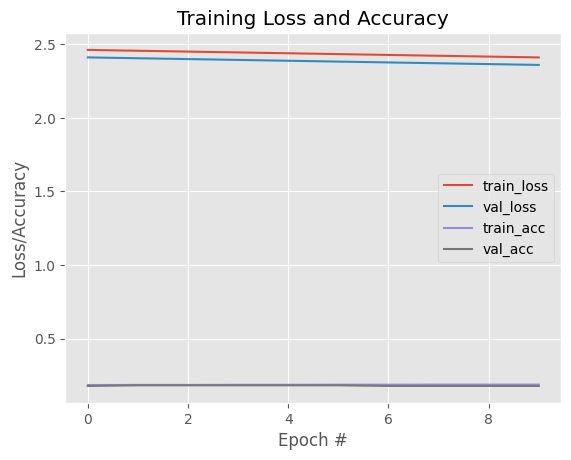

In [36]:
# Hiper-parámetros de nuestra red
lr = 0.001
n_epochs = 10
batch_size = 500

# Implementamos la red empleando Keras
model = Sequential() # Instancia de modelo API secuencial
model.add(Dense(3, input_shape=(13,), activation="softmax")) # Construimos nuestro Perceptrón simple con una única capa Dense

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["accuracy"])
H = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=n_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción con los datos de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_norm, batch_size=batch_size)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis=1)))

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Bastante malo el resultado... Bueno, era de esperar en el sentido de que es un problema complejo y sólo hemos puesto una capa.



---


## Voy a trazar una red más profunda para los datos 1-D/Tabulares: ⏬

[INFO]: Entrenando red neuronal...
Epoch 1/10
14/14 [==============================] - 3s 35ms/step - loss: 1.0865 - accuracy: 0.4257 - val_loss: 1.0900 - val_accuracy: 0.4333
Epoch 2/10
14/14 [==============================] - 0s 8ms/step - loss: 1.0816 - accuracy: 0.4346 - val_loss: 1.0861 - val_accuracy: 0.4417
Epoch 3/10
14/14 [==============================] - 0s 21ms/step - loss: 1.0768 - accuracy: 0.4478 - val_loss: 1.0823 - val_accuracy: 0.4500
Epoch 4/10
14/14 [==============================] - 0s 14ms/step - loss: 1.0721 - accuracy: 0.4544 - val_loss: 1.0786 - val_accuracy: 0.4542
Epoch 5/10
14/14 [==============================] - 0s 9ms/step - loss: 1.0675 - accuracy: 0.4625 - val_loss: 1.0750 - val_accuracy: 0.4667
Epoch 6/10
14/14 [==============================] - 0s 11ms/step - loss: 1.0631 - accuracy: 0.4691 - val_loss: 1.0714 - val_accuracy: 0.4792
Epoch 7/10
14/14 [==============================] - 0s 15ms/step - loss: 1.0586 - accuracy: 0.4809 - val_loss: 1.0679 - v

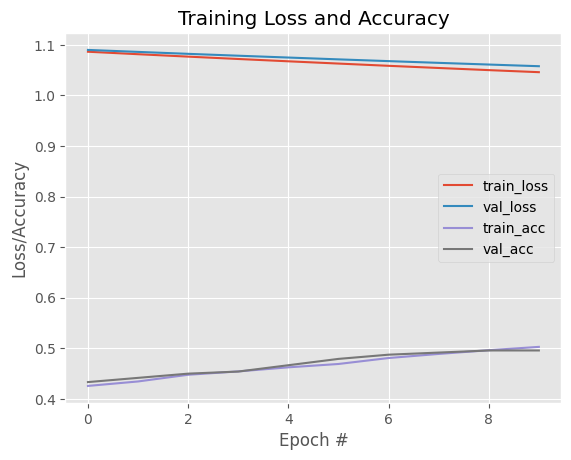

In [37]:
learning_rate = 0.001
num_epochs = 10
batch_size = 100

# Implementamos la red empleando Keras
model = Sequential()
model.add(Dense(64, input_shape=(X_train_norm.shape[1],), activation='relu'))
model.add(Dense(26, activation='relu'))
model.add(Dense(3, activation="softmax"))

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción con los datos de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_norm, batch_size=batch_size)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis=1)))

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Voy a aumentar considerablemente el nº de épocas a ver si mejora el entrenamiento:

[INFO]: Entrenando red neuronal...
Epoch 1/100
14/14 [==============================] - 3s 45ms/step - loss: 1.1778 - accuracy: 0.3022 - val_loss: 1.1563 - val_accuracy: 0.2833
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 1.1700 - accuracy: 0.3081 - val_loss: 1.1490 - val_accuracy: 0.2875
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 1.1626 - accuracy: 0.3125 - val_loss: 1.1420 - val_accuracy: 0.2958
Epoch 4/100
14/14 [==============================] - 0s 13ms/step - loss: 1.1554 - accuracy: 0.3213 - val_loss: 1.1352 - val_accuracy: 0.3083
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 1.1484 - accuracy: 0.3338 - val_loss: 1.1287 - val_accuracy: 0.3167
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 1.1417 - accuracy: 0.3404 - val_loss: 1.1224 - val_accuracy: 0.3333
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 1.1354 - accuracy: 0.3493 - val_loss: 1

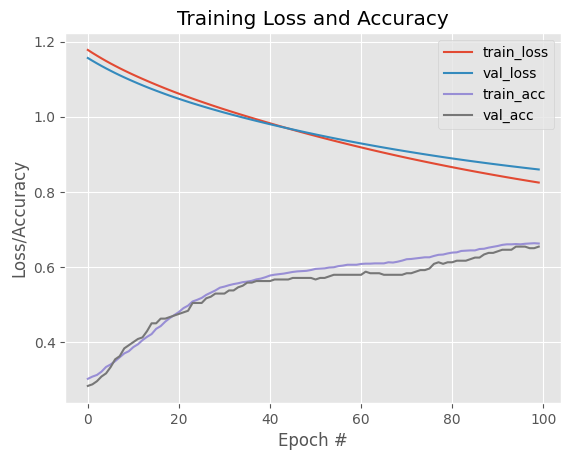

In [38]:
learning_rate = 0.001
num_epochs = 100
batch_size = 100

# Implementamos la red empleando Keras
model = Sequential()
model.add(Dense(64, input_shape=(X_train_norm.shape[1],), activation='relu'))
model.add(Dense(26, activation='relu'))
model.add(Dense(3, activation="softmax"))

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción con los datos de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_norm, batch_size=batch_size)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis=1)))

# Evaluamos el modelo
scores = model.evaluate(X_test_norm, y_test)

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Según se aprecia en la gráfica, todo apunta que a partir de #80 ya progresa casi nada. Voy a dejar en 80 el n_epochs

[INFO]: Entrenando red neuronal...
Epoch 1/80
14/14 [==============================] - 1s 16ms/step - loss: 1.1414 - accuracy: 0.2949 - val_loss: 1.1542 - val_accuracy: 0.3333
Epoch 2/80
14/14 [==============================] - 0s 6ms/step - loss: 1.1370 - accuracy: 0.3022 - val_loss: 1.1497 - val_accuracy: 0.3333
Epoch 3/80
14/14 [==============================] - 0s 5ms/step - loss: 1.1327 - accuracy: 0.3074 - val_loss: 1.1453 - val_accuracy: 0.3375
Epoch 4/80
14/14 [==============================] - 0s 6ms/step - loss: 1.1284 - accuracy: 0.3154 - val_loss: 1.1410 - val_accuracy: 0.3417
Epoch 5/80
14/14 [==============================] - 0s 7ms/step - loss: 1.1243 - accuracy: 0.3213 - val_loss: 1.1367 - val_accuracy: 0.3375
Epoch 6/80
14/14 [==============================] - 0s 7ms/step - loss: 1.1202 - accuracy: 0.3272 - val_loss: 1.1325 - val_accuracy: 0.3583
Epoch 7/80
14/14 [==============================] - 0s 5ms/step - loss: 1.1161 - accuracy: 0.3331 - val_loss: 1.1284 - val_a

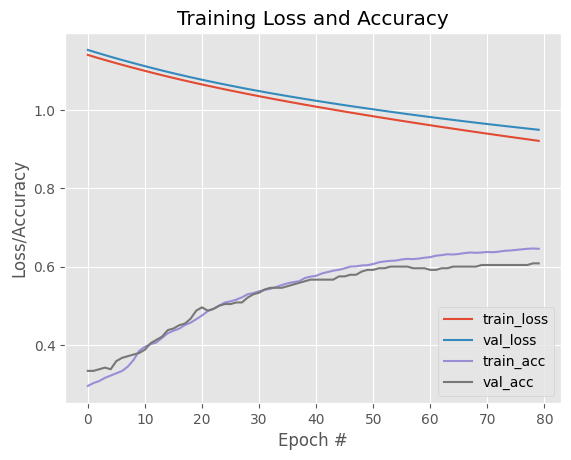

In [39]:
learning_rate = 0.001
num_epochs = 80
batch_size = 100

# Implementamos la red empleando Keras
model = Sequential()
model.add(Dense(64, input_shape=(X_train_norm.shape[1],), activation='relu'))
model.add(Dense(26, activation='relu'))
model.add(Dense(3, activation="softmax"))

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción con los datos de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_norm, batch_size=batch_size)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis=1)))

# Evaluamos el modelo
scores = model.evaluate(X_test_norm, y_test)

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Ahora sería el momento de mejorar este modelo, haciendo uso de las herramientas vistas. Por ejemplo, voy a empezar con Regularización, Dropout:


[INFO]: Entrenando red neuronal...
Epoch 1/80
14/14 [==============================] - 2s 26ms/step - loss: 1.3854 - accuracy: 0.3074 - val_loss: 1.2213 - val_accuracy: 0.3000
Epoch 2/80
14/14 [==============================] - 0s 8ms/step - loss: 1.3842 - accuracy: 0.3191 - val_loss: 1.2136 - val_accuracy: 0.3125
Epoch 3/80
14/14 [==============================] - 0s 8ms/step - loss: 1.3654 - accuracy: 0.3360 - val_loss: 1.2059 - val_accuracy: 0.3042
Epoch 4/80
14/14 [==============================] - 0s 8ms/step - loss: 1.3167 - accuracy: 0.3375 - val_loss: 1.1983 - val_accuracy: 0.3083
Epoch 5/80
14/14 [==============================] - 0s 7ms/step - loss: 1.3307 - accuracy: 0.3250 - val_loss: 1.1913 - val_accuracy: 0.3083
Epoch 6/80
14/14 [==============================] - 0s 9ms/step - loss: 1.2983 - accuracy: 0.3735 - val_loss: 1.1843 - val_accuracy: 0.3125
Epoch 7/80
14/14 [==============================] - 0s 9ms/step - loss: 1.2789 - accuracy: 0.3529 - val_loss: 1.1760 - val_a

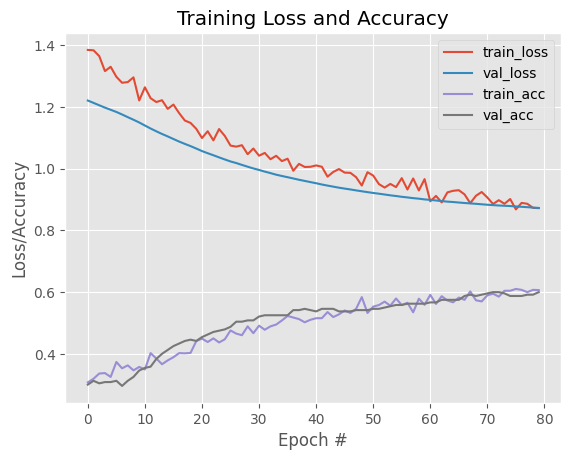

In [40]:
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout

learning_rate = 0.001
num_epochs = 80
batch_size = 100

# Probabilidad de dropout (probabilidad de que un peso w = 0 en entrenamiento)
P = 0.25

# Implementamos la red empleando Keras
model = Sequential()
model.add(Dense(64, input_shape=(X_train_norm.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(P))
model.add(Activation('relu'))

model.add(Dense(26))
model.add(BatchNormalization())
model.add(Dropout(P))
model.add(Activation('relu'))

model.add(Dense(3, activation="softmax"))

# Compilamos y entrenamos el modelo SGD
print("[INFO]: Entrenando red neuronal...")
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Entrenando la solución
H = model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=num_epochs, batch_size=batch_size)

# Evaluando el modelo de predicción con los datos de test
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_norm, batch_size=batch_size)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis=1)))

# Evaluamos el modelo
scores = model.evaluate(X_test_norm, y_test)

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Ha mejorado un poquito la cosa 🙂

Al final hemos conseguido un muy buen resultado de accuracy combinando el nº de épocas (barridos) de los datos, y añadiendo capas de Dropout y BatchNormalization



---



Una vez que tengo una aproximación a los resultados que da la Red Neuronal aplicada a datos 1-D (tabulares), pasamos a predecir los precios basándonos en las imágenes de las habitaciones/apartamentos.






## 2. Procesamos los datos de las imágenes: 🖼

In [41]:
images_train, images_test = train_test_split(saved_imgs, test_size=0.2, random_state=1)
images_train, images_val = train_test_split(images_train, test_size=0.15, random_state=1)


# Verificar los tamaños de los conjuntos
print("Tamaño de train imag:", images_train.shape)
print("Tamaño de train:", X_train.shape)
print("Tamaño de val imag:", images_val.shape)
print("Tamaño de val:", X_val.shape)
print("Tamaño de test imag:", images_test.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de train imag: (1360, 224, 224, 3)
Tamaño de train: (1360, 13)
Tamaño de val imag: (240, 224, 224, 3)
Tamaño de val: (240, 13)
Tamaño de test imag: (400, 224, 224, 3)
Tamaño de test: (400, 13)


Chequeamos que ya estaba hecha la normalización:

In [42]:
images_train.max(), images_train.min()

(1.0, 0.0)

Importamos librerías y herramientas.

In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [44]:
images_train.shape

(1360, 224, 224, 3)

In [45]:
y_train.shape

TensorShape([1360, 3])

## Modelo Baseline de CNN 📈


Empezamos por un modelo *baseline* y haciendo **transfer learning** ⚡ para ver qué tal funciona con nuestros datos. En mi caso, he elegido para empezar **ResNet50**:
*   primero porque el tamaño de las imágenes con el que fue entrenado es el mismo que las de mi dataset ✅

*   y, aparte, es un modelo ideado para un problema de clasificación, como el que estamos tratando ✅



[Info ResNet50 en Hugging Face](https://huggingface.co/microsoft/resnet-50/blob/main/README.md)

In [46]:
# Importamos librerías y demás funciones que vamos a necesitar
from tensorflow.keras.applications import ResNet50, imagenet_utils
import numpy as np
import urllib
import cv2
import matplotlib.pyplot as plt
import imageio as io

from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np

input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape) #include_top=False para añadir nosotros la capa clasificadora que necesitamos
base_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [47]:
# Congelamos todas las capas de nuestro base_model para que no se entrenen
# Queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')


# Cogemos la última capa del baseline model y le añadimos nuestro clasificador, que es de 3 neuronas (1 por categoría de precios)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax', name='predictions')(x) #3 categorías de precios
model = Model(base_model.input, x)

# compilamos el modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# vemos la estructura del modelo
#model.summary()

Capa input_1 congelada.
Capa conv1_pad congelada.
Capa conv1_conv congelada.
Capa conv1_bn congelada.
Capa conv1_relu congelada.
Capa pool1_pad congelada.
Capa pool1_pool congelada.
Capa conv2_block1_1_conv congelada.
Capa conv2_block1_1_bn congelada.
Capa conv2_block1_1_relu congelada.
Capa conv2_block1_2_conv congelada.
Capa conv2_block1_2_bn congelada.
Capa conv2_block1_2_relu congelada.
Capa conv2_block1_0_conv congelada.
Capa conv2_block1_3_conv congelada.
Capa conv2_block1_0_bn congelada.
Capa conv2_block1_3_bn congelada.
Capa conv2_block1_add congelada.
Capa conv2_block1_out congelada.
Capa conv2_block2_1_conv congelada.
Capa conv2_block2_1_bn congelada.
Capa conv2_block2_1_relu congelada.
Capa conv2_block2_2_conv congelada.
Capa conv2_block2_2_bn congelada.
Capa conv2_block2_2_relu congelada.
Capa conv2_block2_3_conv congelada.
Capa conv2_block2_3_bn congelada.
Capa conv2_block2_add congelada.
Capa conv2_block2_out congelada.
Capa conv2_block3_1_conv congelada.
Capa conv2_block

In [48]:
# comenzamos con el entrenamiento
epochs = 5
batch_size = 32

# como entrenariamos normalmente, chequeando contra conjunto de validación para ir afinando el modelo
model.fit(images_train, y_train,
          batch_size=batch_size,
          validation_data=(images_val, y_val),
          epochs=epochs)

Epoch 1/5
43/43 [==============================] - 16s 171ms/step - loss: 8.6592 - accuracy: 0.3603 - val_loss: 2.0012 - val_accuracy: 0.3625
Epoch 2/5
43/43 [==============================] - 6s 141ms/step - loss: 1.2355 - accuracy: 0.3875 - val_loss: 1.1022 - val_accuracy: 0.3375
Epoch 3/5
43/43 [==============================] - 6s 137ms/step - loss: 1.0707 - accuracy: 0.4257 - val_loss: 1.0924 - val_accuracy: 0.3417
Epoch 4/5
43/43 [==============================] - 6s 138ms/step - loss: 1.0516 - accuracy: 0.4493 - val_loss: 1.0838 - val_accuracy: 0.4042
Epoch 5/5
43/43 [==============================] - 6s 139ms/step - loss: 1.0506 - accuracy: 0.4515 - val_loss: 1.0775 - val_accuracy: 0.4458


### Entrenando a lo largo de 5 épocas nos salen valores de accuracy bastante buenos: 40% en Train y 36.2% en Validation!!

Voy a probar con **fine-tuning** ⚡

Copio tal cual el modelo implementado arriba

In [49]:
input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#Miro el summary independiente para verificar el nombre de la última capa:
#base_model.summary()

La última capa convolucional se llama *conv5_block3_conv*

In [50]:
# permitimos que, además de la etapa de clasificación, se entrenen también el
# último bloque convolucional
for layer in base_model.layers:
  layer.trainable = False
  if layer.name == "conv5_block3_3_conv": #nombre de la última capa convolucional
    layer.trainable = True

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax', name='predictions')(x) #3 categorías de precios
model = Model(base_model.input, x)

# compilamos el modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# vemos la nueva estructura del modelo
#model.summary()

Vamos a ver qué tal ha ido este reentrenamiento de la última capa ...

In [51]:
# comenzamos con el entrenamiento
epochs = 5
batch_size = 32

# como entrenariamos normalmente, chequeando contra conjunto de validación para ir afinando el modelo
model.fit(images_train, y_train,
          batch_size=batch_size,
          validation_data=(images_val, y_val),
          epochs=epochs)

Epoch 1/5
43/43 [==============================] - 13s 163ms/step - loss: 6.7350 - accuracy: 0.3463 - val_loss: 1.0896 - val_accuracy: 0.3750
Epoch 2/5
43/43 [==============================] - 6s 133ms/step - loss: 1.0892 - accuracy: 0.3853 - val_loss: 1.1686 - val_accuracy: 0.3208
Epoch 3/5
43/43 [==============================] - 6s 131ms/step - loss: 1.0765 - accuracy: 0.4250 - val_loss: 1.0835 - val_accuracy: 0.4125
Epoch 4/5
43/43 [==============================] - 6s 147ms/step - loss: 1.0423 - accuracy: 0.4574 - val_loss: 1.0801 - val_accuracy: 0.3958
Epoch 5/5
43/43 [==============================] - 6s 132ms/step - loss: 1.0442 - accuracy: 0.4493 - val_loss: 1.0865 - val_accuracy: 0.4333


Ha mejorado un poco el accuracy 🙂 Un 44% en Train y un 44% sobre el conjunto de Validation! 🎉




Voy a ver qué sucede si reentreno las dos últimas capas, esta vez:

In [52]:
# permitimos que, además de la etapa de clasificación, se entrenen también el
# último bloque convolucional
for layer in base_model.layers:
  layer.trainable = False
  if layer.name == "conv5_block3_3_conv": #nombre de las 2 últimas capas convolucionales
    layer.trainable = True
  elif layer.name == "conv5_block3_2_conv": #nombre de las 2 últimas capas convolucionales
    layer.trainable = True

# Ahora ya cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax', name='predictions')(x) #3 categorías de precios
model = Model(base_model.input, x)

# compilamos el modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# vemos la nueva estructura del modelo
#model.summary()

In [53]:
# comenzamos con el entrenamiento
epochs = 5
batch_size = 32

# como entrenariamos normalmente, chequeando contra conjunto de validación para ir afinando el modelo
model.fit(images_train, y_train,
          batch_size=batch_size,
          validation_data=(images_val, y_val),
          epochs=epochs)

Epoch 1/5
43/43 [==============================] - 12s 171ms/step - loss: 1.2806 - accuracy: 0.3154 - val_loss: 1.1219 - val_accuracy: 0.3125
Epoch 2/5
43/43 [==============================] - 6s 136ms/step - loss: 1.1460 - accuracy: 0.3353 - val_loss: 1.0988 - val_accuracy: 0.3250
Epoch 3/5
43/43 [==============================] - 6s 139ms/step - loss: 1.0983 - accuracy: 0.3574 - val_loss: 1.0989 - val_accuracy: 0.3250
Epoch 4/5
43/43 [==============================] - 6s 150ms/step - loss: 1.0979 - accuracy: 0.3574 - val_loss: 1.0992 - val_accuracy: 0.3250
Epoch 5/5
43/43 [==============================] - 7s 154ms/step - loss: 1.0976 - accuracy: 0.3574 - val_loss: 1.0995 - val_accuracy: 0.3250


Pues en este caso han empeorado las prestaciones, voy a bajar un poco el batch_size que por experiencia previa juega un papel importante y aumentar el nº de épocas:


In [54]:
# comenzamos con el entrenamiento
epochs = 10
batch_size = 24

# como entrenariamos normalmente, chequeando contra conjunto de validación para ir afinando el modelo
model.fit(images_train, y_train,
          batch_size=batch_size,
          validation_data=(images_val, y_val),
          epochs=epochs)

Epoch 1/10
57/57 [==============================] - 8s 126ms/step - loss: 1.0976 - accuracy: 0.3574 - val_loss: 1.0999 - val_accuracy: 0.3250
Epoch 2/10
57/57 [==============================] - 7s 120ms/step - loss: 1.0977 - accuracy: 0.3574 - val_loss: 1.0998 - val_accuracy: 0.3250
Epoch 3/10
57/57 [==============================] - 7s 121ms/step - loss: 1.0976 - accuracy: 0.3574 - val_loss: 1.1002 - val_accuracy: 0.3250
Epoch 4/10
57/57 [==============================] - 7s 121ms/step - loss: 1.0973 - accuracy: 0.3574 - val_loss: 1.1004 - val_accuracy: 0.3250
Epoch 5/10
57/57 [==============================] - 7s 120ms/step - loss: 1.0978 - accuracy: 0.3574 - val_loss: 1.0999 - val_accuracy: 0.3250
Epoch 6/10
57/57 [==============================] - 20s 362ms/step - loss: 1.0973 - accuracy: 0.3574 - val_loss: 1.1003 - val_accuracy: 0.3250
Epoch 7/10
57/57 [==============================] - 7s 121ms/step - loss: 1.0974 - accuracy: 0.3574 - val_loss: 1.1004 - val_accuracy: 0.3250
Epoch

Nada, son malos resultados, la red no está aprendiendo nada. Me quedo con el primer modelo, que generalizaba mejor en el conjunto de Validación con respecto al 2º modelo (en el que entrenaba la última capa convolucional) y corría menos riesgo de *overfitting*:

In [55]:
input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Cogemos la última capa del baseline model y le añadimos nuestro clasificador, que es de 3 neuronas (1 por categoría de precios)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax', name='predictions')(x) #3 categorías de precios
model_img = Model(base_model.input, x)

# compilamos el modelo
model_img.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


## Ahora es el momento de probar este modelo contra el conjunto de Test!! 🤞

In [56]:
scores = model_img.evaluate(images_test, y_test, verbose=1)
print('ResNet50 Customized Test loss:', scores[0])
print('ResNet50 Customized Test accuracy:', scores[1])

13/13 [==============================] - 3s 97ms/step - loss: 1.7914 - accuracy: 0.3550
ResNet50 Customized Test loss: 1.7913705110549927
ResNet50 Customized Test accuracy: 0.35499998927116394


## 3. Modelo combinado "Fusión" de imágenes + datos tabulares

Vamos a emplear dos filosofías diferentes para la fusión de los modelos obtenidos:


**1.   Early Fusion**:  *Extraer features de las imágenes (usar partes de una red entrenada como feature extractor)* y concatenar ese vector con los datos numéricos. Emplear un modelo que vea ese súper-vector como input para realizar la predicción. Se denomina early-fusion porque la decisión de regresión/clasificación se realiza a partir de una combinación temprana de las features. En otras palabras: juntar la representación del input para el sistema 1D y el vector de salida de la última capa convolucional. Cada muestra queda representada por un vector de tamaño #de inputs 1D + longitud vector de la salida convolucional. Aprender un clasificador ML tradicional usando ese supervector (cada muestra es uno de esos vectores) como entrada.



**2.   Late Fusion**: Operar normalmente con dos modelos (datos tabulares-numéricos, imágenes) y emitir predicciones independientes. Emplear las predicciones como inputs para un modelo que vea las 2 predicciones como input para el clasificador/regresión. Ejemplo: Para la muestra x, el uso de datos tabulares predice 0.7; usando imágenes, 0.84. El “nuevo” input será el vector [0.7, 0.84].  En otras palabras: juntar las predicciones hechas del sistema 1D y el de imágenes. Se hace para train y test. Cada muestra queda definida como un vector de 2 elementos que son la entrada a un clasificador de ML tradicional (o regresor)





---



### EARLY- FUSION : Así, para *early-fusion*, necesitamos los **datos tabulares** por un lado y la **extracción de features** por el otro:

In [57]:
#DATOS TABULARES - 1D
# X_train_norm
# X_val_norm
# X_test_norm

Veo la composición del modelo ResNet50 personalizado que escogí antes:

In [58]:
model_img.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Ahora, para llevar a cabo *early-fusion* necesito crear un modelo copia del completo, pero que no tenga las capas clasificadoras. Que acabe, por tanto, en la capa *flatten_3*:

In [59]:
last_conv = model_img.layers[-5].output #esta es la salida Conv2D con BatchNorm y Activation
a = Flatten()(last_conv)

model_ef = Model(model_img.input, a)

model_ef.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [60]:
pred_model_img_ef = model_ef.predict(images_train)
pred_model_img_ef

43/43 [==============================] - 5s 86ms/step


array([[0.       , 0.       , 0.       , ..., 4.5559363, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.8054695, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.4522142, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.633566 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.347883 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.7124987, 0.       ,
        0.       ]], dtype=float32)

Concateno las "predicciones" (procesamiento) de este Modelo para Early Fusion con los datos 1D:

In [61]:
from tensorflow.keras.layers import concatenate

combined_feat_train_ef = concatenate([np.array(X_train_norm), model_ef.predict(images_train)])

#IDEM PARA VAL
combined_feat_val_ef = concatenate([np.array(X_val_norm), model_ef.predict(images_val)])

#IDEM PARA TEST
combined_feat_test_ef = concatenate([np.array(X_test_norm), model_ef.predict(images_test)])

13/13 [==============================] - 1s 86ms/step


Las etiquetas, el *ground-truth*, ya las tenemos desde el origen:

In [62]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1360, 3)
(240, 3)
(400, 3)


Y pruebo un algoritmo RandomForest a ver qué tal funciona con esta combinación de datos:

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3, n_estimators=200, max_features='sqrt').fit(combined_feat_train_ef, y_train)

print("Precisión de RandomForest en el conjunto de validación (Early Fusion): ", rf.score(combined_feat_val_ef, y_val))

print("RandomForest Train Score (Early Fusion): ",rf.score(combined_feat_train_ef, y_train))
print("RandomForest Test Score (Early Fusion): ",rf.score(combined_feat_test_ef, y_test))

Precisión de RandomForest en el conjunto de validación (Early Fusion):  0.041666666666666664
RandomForest Train Score (Early Fusion):  0.10735294117647058
RandomForest Test Score (Early Fusion):  0.1125


Es un resultado bastante malo ... no es una estrategia competitiva para este problema, con este volumen de datos, etc.

### Ahora probamos con *LATE FUSION*:



**Late-fusion: juntar las predicciones hechas del sistema 1D y el de imágenes**. Se hace para train y test. Cada muestra queda definida como un vector de 2 elementos que son la entrada a un clasificador de ML tradicional

Predicciones del Modelo 1D (elijo XGBoost):

In [64]:
pred_model_1D = xgboost_model.predict(np.array(X_train_norm))
pred_model_1D

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

Predicciones de mi ResNet sobre las imágenes:

In [65]:
pred_model_img = model_img.predict(images_train)
pred_model_img

43/43 [==============================] - 5s 96ms/step


array([[0.85342294, 0.06720258, 0.07937443],
       [0.8459337 , 0.09473099, 0.05933541],
       [0.84067017, 0.09772176, 0.06160812],
       ...,
       [0.87568367, 0.06882804, 0.05548834],
       [0.8669868 , 0.06247742, 0.07053574],
       [0.8789343 , 0.05305219, 0.06801341]], dtype=float32)

Concateno ambas predicciones, en los 3 conjuntos que manejamos:

In [66]:
from tensorflow.keras.layers import concatenate

combined_feat_train_lf = concatenate([xgboost_model.predict(np.array(X_train_norm)), model_img.predict(images_train)])

#IDEM PARA VAL
combined_feat_val_lf = concatenate([xgboost_model.predict(np.array(X_val_norm)), model_img.predict(images_val)])

#IDEM PARA TEST
combined_feat_test_lf = concatenate([xgboost_model.predict(np.array(X_test_norm)), model_img.predict(images_test)])

13/13 [==============================] - 1s 96ms/step


Ahora, con esa combinación de **predicciones** entreno un modelo de RandomForest y veo sus métricas:

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3,n_estimators=200,max_features='sqrt').fit(combined_feat_train_lf, y_train)

print("Precisión de RandomForest en el conjunto de validación (Late Fusion): ", rf.score(combined_feat_val_lf, y_val))

print("RandomForest Train Score (Late Fusion): ",rf.score(combined_feat_train_lf, y_train))
print("RandomForest Test Score (Late Fusion): ",rf.score(combined_feat_test_lf, y_test))

Precisión de RandomForest en el conjunto de validación (Late Fusion):  0.6625
RandomForest Train Score (Late Fusion):  0.7602941176470588
RandomForest Test Score (Late Fusion):  0.685


Mucho mejor resultado que con *Early Fusion*, de hecho una notable mejoría también con respecto a las Redes Neuronales tratando solo con imágenes y unas métricas equiparables al modelo XGBoost en datos tabulares (poco procesados) que hice al principio.



---

